In [1]:
from os.path import join

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import yaml
from matplotlib.lines import Line2D
from sbibm.visualisation import fig_posterior
import pandas as pd

# Download data from WANDB
And put them in dataframes

In [2]:
from utils import obtain_wandb_data

In [37]:
runs_list, runs_list_GAN, runs_list_SRs = obtain_wandb_data(["SLCP", "TwoMoons", "GaussianMixture", "GaussianLinear", "BernoulliGLM"])

In [38]:
len(runs_list)

5

In [39]:
runs_df_slcp, runs_df_two_moons, runs_df_gaussian_mixture, runs_df_gaussian_linear, runs_df_bernoulli_glm = runs_list
runs_df_slcp_GAN, runs_df_two_moons_GAN, runs_df_gaussian_mixture_GAN, runs_df_gaussian_linear_GAN, runs_df_bernoulli_glm_GAN = runs_list_GAN
runs_df_slcp_SRs, runs_df_two_moons_SRs, runs_df_gaussian_mixture_SRs, runs_df_gaussian_linear_SRs, runs_df_bernoulli_glm_SRs = runs_list_SRs

In [40]:
print(len(runs_df_slcp_GAN), len(runs_df_two_moons_GAN), len(runs_df_gaussian_mixture_GAN), len(runs_df_gaussian_linear_GAN), len(runs_df_bernoulli_glm_GAN))

3 3 3 3 3


In [41]:
print(len(runs_df_slcp_SRs), len(runs_df_two_moons_SRs), len(runs_df_gaussian_mixture_SRs), len(runs_df_gaussian_linear_SRs), len(runs_df_bernoulli_glm_SRs))

24 24 24 24 24


In [42]:
runs_df_slcp.columns

Index(['name', 'ID', 'epochs', 'gen_seed', 'net_type', 'sample_seed',
       'stop_thresh', 'gen_opt_args', 'scoring_rule', 'hold_out_perc',
       'batch_size_perc', 'gen_network_kwargs', 'num_training_simulations',
       'num_simulations_generator', '_timestamp', '_step', 'c2st_std',
       'gen_loss', 'sbc_hist', 'r2_val_mean', 'rmse_val_std', 'rmse_val_mean',
       'c2st', '_wandb', '_runtime', 'gen_grad', 'kernel_bandwidth',
       'early_stop_at_epoch', 'r2_val_std', 'global_step', 'cal_err_val_std',
       'cal_err_val_mean', 'c2st_mean', 'train_time', 'loss', 'dis_iter',
       'dis_seed', 'gen_iter', 'hold_out', 'dis_units', 'dis_nonlin',
       'dis_opt_args', 'max_norm_dis', 'max_norm_gen', 'num_simulations',
       'dis_nonlin_kwargs', 'dfake_std', 'dreal_mean', 'dis_loss', 'dreal_std',
       'dfake_mean', 'dis_grad'],
      dtype='object')

In [43]:
runs_df_slcp

,name,ID,epochs,gen_seed,net_type,sample_seed,stop_thresh,gen_opt_args,scoring_rule,hold_out_perc,...,max_norm_dis,max_norm_gen,num_simulations,dis_nonlin_kwargs,dfake_std,dreal_mean,dis_loss,dreal_std,dfake_mean,dis_grad
0,slcp_kernel_score_1000_5,28g9i6m4,20000.0,None,mlp,41,0.001,"[0.001, [0.9, 0.99]]",kernel_score,0.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,slcp_kernel_score_1000_3,x70fru7o,20000.0,None,mlp,42,0.001,"[0.001, [0.9, 0.99]]",kernel_score,0.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,slcp_kernel_score_1000_20,3lfxm5us,20000.0,None,mlp,43,0.001,"[0.001, [0.9, 0.99]]",kernel_score,0.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,slcp_kernel_score_1000_10,vd676pqp,20000.0,None,mlp,43,0.001,"[0.001, [0.9, 0.99]]",kernel_score,0.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,slcp_energy_score_1000_10,5ddbobqz,20000.0,None,mlp,43,0.001,"[0.001, [0.9, 0.99]]",energy_score,0.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,slcp_energy_score_1000_5,1wlurezc,20000.0,None,mlp,42,0.001,"[0.001, [0.9, 0.99]]",energy_score,0.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,slcp_energy_score_1000_3,2w535klr,20000.0,None,mlp,42,0.001,"[0.001, [0.9, 0.99]]",energy_score,0.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,slcp_energy_score_1000_20,35p80m1u,20000.0,None,mlp,42,0.001,"[0.001, [0.9, 0.99]]",energy_score,0.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,slcp_energy_score_10000_10,1ajmp2kw,20000.0,None,mlp,42,0.001,"[0.001, [0.9, 0.99]]",energy_score,0.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,slcp_kernel_score_100000_5,1ma1azze,20000.0,None,mlp,42,0.001,"[0.001, [0.9, 0.99]]",kernel_score,0.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Load the results with the flow matching paper (Dax et al) 

In [41]:
df_dax = pd.read_csv("plotting_data/metrics_Dax.csv")

In [42]:
# create a dataframe containing the mean and std of the c2st, in columns c2st_mean and c2st_std
df_dax_c2st = df_dax.groupby(["task", "number_simulations"]).agg({"c2st": ["mean", "std"]}).reset_index()
df_dax_c2st.columns = ["task", "number_simulations", "c2st_mean", "c2st_std"]
df_dax_c2st

,task,number_simulations,c2st_mean,c2st_std
0,bernoulli_glm,1000,0.818330,0.039267
1,bernoulli_glm,10000,0.666755,0.027640
2,bernoulli_glm,100000,0.533695,0.017169
3,bernoulli_glm_raw,1000,0.959055,0.015824
4,bernoulli_glm_raw,10000,0.598590,0.014153
5,bernoulli_glm_raw,100000,0.531125,0.011751
6,gaussian_linear,1000,0.562635,0.006398
7,gaussian_linear,10000,0.535910,0.006751
8,gaussian_linear,100000,0.503190,0.003417
9,gaussian_linear_uniform,1000,0.628714,0.044073


# Calibration metrics with respect to n_gen and n_sim

The following extracts the metrics from the dataframe and puts them in a dictionary of dictionaries.

In [9]:
def extract_dict_from_df(metrics, tasks, runs_list, labels, algos, algos_labels, colors, n_simulations, n_generator, alphas, lss):

    metrics_dict = {task:{} for task in tasks}
    
    for task, task_df  in zip(tasks, runs_list):
        # print(task)
        for algo, algo_label, color in zip(algos, algos_labels, colors):
            # print(algo)
            if algo == "GAN":
                metrics_dict_single = {metric: [] for metric in metrics}
                for n_sim in n_simulations:
                    # print("n_sim", n_sim)
                    entry = task_df[task_df["name"] == f"{task}_{algo}_{n_sim}_"]
                    for metric in metrics: 
                        metrics_dict_single[metric].append(entry[metric].item())
                    metrics_dict_single["algo_label"] = algo_label
                    metrics_dict_single["color"] = color
                    metrics_dict_single["alpha"] = 1
                    metrics_dict_single["ls"] = "solid"

                metrics_dict[f"{task}"][f"{algo}"] = metrics_dict_single

            else:
                for n_gen, alpha, ls in zip(n_generator, alphas, lss):
                    # print("n_gen", n_gen)
                    metrics_dict_single = {metric: [] for metric in metrics}
                    for n_sim in n_simulations:
                        # print("n_sim", n_sim)
                        entry = task_df[task_df["name"] == f"{task}_{algo}_{n_sim}_{n_gen}"]
                        for metric in metrics: 
                            # print(metric)
                            # print(entry[metric])
                            metrics_dict_single[metric].append(entry[metric].item())
                        metrics_dict_single["algo_label"] = algo_label + f" {n_gen}"
                        metrics_dict_single["color"] = color
                        metrics_dict_single["alpha"] = alpha
                        metrics_dict_single["ls"] = ls

                    metrics_dict[f"{task}"][f"{algo}_{n_gen}"] = metrics_dict_single
    return metrics_dict


Do now for the original runs: 

## Plots

### GAN and SR methods only

In [49]:
tasks = ["slcp", "two_moons"]
labels = ["SLCP", "Two Moons"]
tasks_new = ["gaussian_mixture", "gaussian_linear", "bernoulli_glm"]
labels_new = ["Gaussian Mixture", "Gaussian Linear", "Bernoulli GLM"]
algos = ["GAN", "energy_score", "kernel_score"]
algos_labels = ["GATSBI", "Energy", "Kernel"]
#algos = ["energy_score", "kernel_score"]
#algos_labels = ["Energy", "Kernel"]
colors = ["tab:red", "tab:green", "tab:olive"]

n_simulations = [1000, 10000, 100000]
n_generator = [3, 5, 10, 20]
alphas = [.1, .4, .7, 1]
lss = ["dotted", "dashed", "dashdot", "solid"]

In [50]:
metrics = ["c2st_mean", "c2st_std", 'rmse_val_std', 'rmse_val_mean', 'cal_err_val_std', 'cal_err_val_mean', 
           'r2_val_std', 'r2_val_mean', '_runtime', 'global_step']

In [51]:
metrics_dict = extract_dict_from_df(metrics=metrics, tasks=tasks, runs_list=runs_list, labels=labels, algos=algos, algos_labels=algos_labels,
colors=colors, n_simulations=n_simulations, n_generator=n_generator, alphas=alphas, lss=lss)

In [64]:
def plot_benchmark_metrics(tasks, labels, metrics_dict, mean_metric, std_metric, ylabel, ylim=None, yticks=None):

    fig, axes = plt.subplots(1, len(tasks), figsize=(1.25*8.27 * len(tasks)/2, 3.))
    fig.subplots_adjust(wspace=.275)
    with mpl.rc_context(fname='./matplotlibrc'):

        for j, (task, ax, ttl) in enumerate(zip(tasks, axes, labels)):

            for run in metrics_dict[task]:
                dict_single = metrics_dict[task][run]
                                    
                ax.errorbar(range(3),
                            dict_single[mean_metric],
                            yerr=dict_single[std_metric],
                            color=dict_single["color"],
                            #alpha=dict_single["alpha"],
                            label=dict_single["algo_label"],
                            ls = dict_single["ls"],
                            lw=2.0)

            #if j==0:
            #    ax.legend(frameon=False)

    #        if j==1:
    #            custom_lines = [Line2D([0], [0], color="tab:red", lw=2.0, linestyle="dashed"),
    #                             Line2D([0], [0], color="tab:red", lw=2.0, linestyle="dotted")
    #                            ]
    #            ax.legend(custom_lines, ['GATSBI: opt. hyperparams',
    #                                      'Seq. GATSBI EBM'
    #                                    ], 
    #                      loc="lower left")

            ax.set_xlim([-0.05, 2.05])
            ax.set_xticks([0, 1, 2])
            if yticks is not None:
                ax.set_yticks(yticks)

            #ax.set_xticklabels([r"$10^3$", r"$10^4$", r"$10^5$"])
            ax.set_xticklabels([r"1000", "10 000", "100 000"])
            ax.set_ylim(ylim)
            ax.set_xlabel("Number of simulations")
            ax.set_ylabel(ylabel)
            ax.set_title(ttl)
        
        fig.text(0.05, .89, "A", fontsize=18)
        if len(tasks) == 2:
            fig.text(0.48, .89, "B", fontsize=18)
        elif len(tasks) == 3:
            fig.text(0.35, .89, "B", fontsize=18)
            fig.text(0.65, .89, "C", fontsize=18)

        plt.subplots_adjust(hspace=2.)

        #plt.savefig("plots/Figure2.pdf")
        
        plt.legend(bbox_to_anchor=(1.06,0.5), loc="center left", frameon=True)
    
    return fig, axes

C2ST: the smaller the better

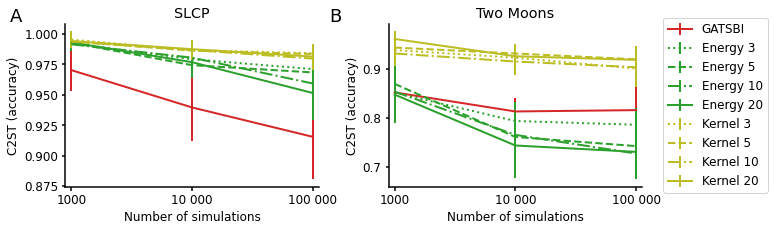

In [53]:
fig, axes = plot_benchmark_metrics(tasks, labels, metrics_dict, "c2st_mean", "c2st_std", "C2ST (accuracy)", None, None)
fig.savefig("plots/C2ST_figure.pdf")
#fig, axes = plot_benchmark_metrics(tasks, labels, metrics_dict, "c2st_mean", "c2st_std", "C2ST (accuracy)", (0.5,1), [0.5, .75, 1.])

Cal error: the smaller the better

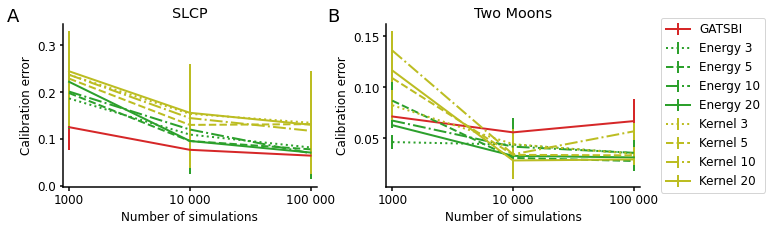

In [85]:
fig, axes = plot_benchmark_metrics(tasks, labels, metrics_dict, "cal_err_val_mean", "cal_err_val_std", "Calibration error", None)
fig.savefig("plots/benchmarks_cal_err_figure.pdf")

For the new tasks

In [60]:
tasks_new = ["gaussian_mixture", "gaussian_linear", "bernoulli_glm"]
labels_new = ["Gaussian Mixture", "Gaussian Linear", "Bernoulli GLM"]
algos = ["GAN", "energy_score", "kernel_score"]
algos_labels = ["GATSBI", "Energy", "Kernel"]
colors = ["tab:red", "tab:green", "tab:olive"]

n_simulations = [1000, 10000, 100000]
n_generator = [3, 5, 10, 20]
alphas = [.1, .4, .7, 1]
lss = ["dotted", "dashed", "dashdot", "solid"]

In [61]:
metrics = ["c2st_mean", "c2st_std",] # 'cal_err_val_std', 'cal_err_val_mean', 
           # '_runtime', 'global_step']

In [62]:
metrics_dict = extract_dict_from_df(metrics=metrics, tasks=tasks_new, runs_list=[runs_df_gaussian_mixture, runs_df_gaussian_linear, runs_df_bernoulli_glm], labels=labels_new, algos=algos, algos_labels=algos_labels,
colors=colors, n_simulations=n_simulations, n_generator=n_generator, alphas=alphas, lss=lss)

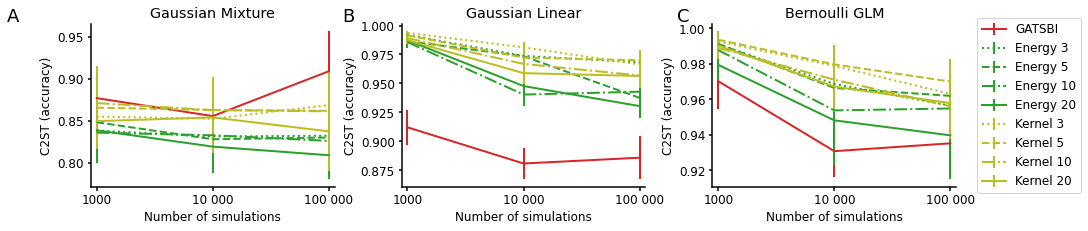

In [63]:
fig, axes = plot_benchmark_metrics(tasks_new, labels_new, metrics_dict, "c2st_mean", "c2st_std", "C2ST (accuracy)", None, None)
fig.savefig("plots/C2ST_figure_new_tasks.pdf")
#fig, axes = plot_benchmark_metrics(tasks, labels, metrics_dict, "c2st_mean", "c2st_std", "C2ST (accuracy)", (0.5,1), [0.5, .75, 1.])

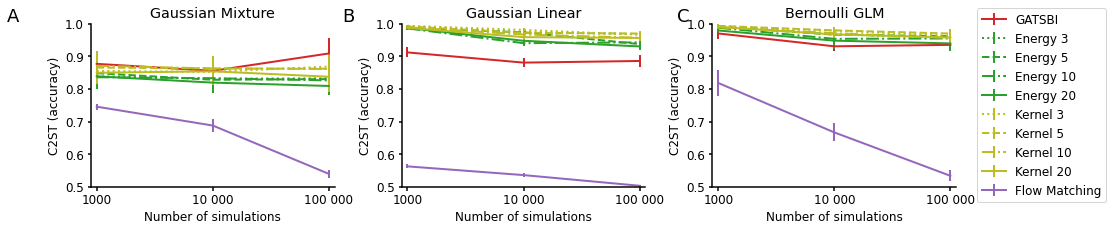

In [116]:
# same as before but also adding Dax et al. (flow matching)
fig, axes = plot_benchmark_metrics(tasks_new, labels_new, metrics_dict, "c2st_mean", "c2st_std", "C2ST (accuracy)", None, None)
for task, ax in zip(tasks_new, axes):
    dict_single = df_dax_c2st[df_dax_c2st.task == task]
    ax.errorbar(range(3),
                list(dict_single["c2st_mean"].to_numpy()),
                yerr=list(dict_single["c2st_std"].to_numpy()),
                color="tab:purple",
                label="Flow Matching",
                lw=2.0)
    # reset the y axis span
    ax.set_ylim((0.5, 1.))

# regenerate the legend
plt.legend(bbox_to_anchor=(1.06,0.5), loc="center left", frameon=True)
fig.savefig("plots/C2ST_figure_new_tasks_with_Dax.pdf")

#fig, axes = plot_benchmark_metrics(tasks, labels, metrics_dict, "c2st_mean", "c2st_std", "C2ST (accuracy)", (0.5,1), [0.5, .75, 1.])

## All methods (this only includes the $m=20$ runs), for the original two problems

In [117]:
runs_df_slcp_SRs_20 = runs_df_slcp_SRs[runs_df_slcp_SRs["num_simulations_generator"] == 20]
runs_df_two_moons_SRs_20 = runs_df_two_moons_SRs[runs_df_two_moons_SRs["num_simulations_generator"] == 20]
runs_list_SRs_20 = [runs_df_slcp_SRs_20, runs_df_two_moons_SRs_20]

In [118]:
tasks = ["slcp", "two_moons"]
labels = ["SLCP", "Two Moons"]
algos = ["energy_score", "kernel_score"]
algos_labels = ["Energy Score", "Kernel Score"]
colors = ["tab:green", "tab:olive"]

n_simulations = [1000, 10000, 100000]
n_generator = [20]
alphas = [1]
lss = ["solid"]

In [119]:
metrics_dict_SRs_20 = extract_dict_from_df(metrics=metrics, tasks=tasks, runs_list=runs_list_SRs_20, labels=labels, algos=algos, algos_labels=algos_labels,
colors=colors, n_simulations=n_simulations, n_generator=n_generator, alphas=alphas, lss=lss)

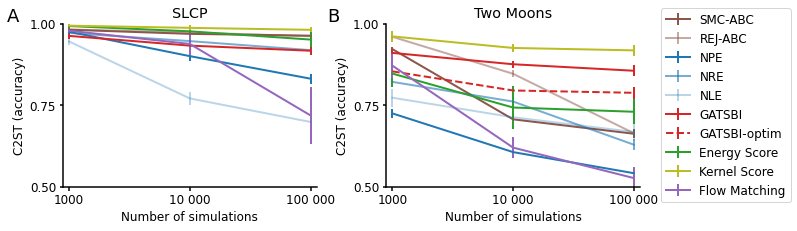

In [120]:
tasks = ["slcp", "two_moons"]
labels = ["SLCP", "Two Moons"]
algos = ["GATSBI", "NLE", "NRE", "NPE","REJ-ABC", "SMC-ABC"]
colors = [*["tab:brown"]*2, *["tab:blue"]*3,"tab:red"]
alphas = [1., .5, 1., .6, .3, 1.]


model_perf = {}
for task in tasks:
    with open(join("plotting_data/", 
                   "%s_c2st_scores.yaml"  % task), 
              "r") as f:
        model_perf[task] = yaml.load(f, Loader=yaml.FullLoader)


fig, axes = plt.subplots(1, 2, figsize=(1.25*8.27, 3.))
fig.subplots_adjust(wspace=.275)
with mpl.rc_context(fname='./matplotlibrc'):

    for j, (task, ax, ttl) in enumerate(zip(tasks, axes, labels)):
        mdl = model_perf[task]["c2st_mean"]
        sem = model_perf[task]["c2st_sem"]
        
        # first do the original methods
        for i, (alg, color, alpha) in enumerate(zip(algos[::-1],
                                                    colors,
                                                    alphas)):
            ax.errorbar(range(3),
                        mdl[alg],
                        yerr=sem[alg],
                        color=color,
                        alpha=alpha,
                        label=alg,
                        lw=2.0)
            
        if task == "two_moons":
            alg = "GATSBI-optim"
            ax.errorbar(range(3),
                        mdl[alg],
                        yerr=sem[alg],
                        color="tab:red",
                        linestyle="dashed",
                        alpha=1.,
                        label="GATSBI-optim",
                        lw=2.0)
#             alg = "GATSBI-EBM"
#             ax.errorbar(range(3),
#                         mdl[alg],
#                         yerr=sem[alg],
#                         color="tab:red",
#                         linestyle="dotted",
#                         alpha=1.,
#                         label="GATSB_EBM",
#                         lw=2.0)

        # then do the SR methods
        for run in metrics_dict_SRs_20[task]:
                dict_single = metrics_dict_SRs_20[task][run]
                                    
                ax.errorbar(range(3),
                            dict_single["c2st_mean"],
                            yerr=dict_single["c2st_std"],
                            color=dict_single["color"],
                            #alpha=dict_single["alpha"],
                            label=dict_single["algo_label"][:-3],
                            ls = dict_single["ls"],
                            lw=2.0)
            
        # then add the method by Dax et al. (flow matching, kindly provided by the authors)
        dict_single = df_dax_c2st[df_dax_c2st.task == task]
        ax.errorbar(range(3),
                    list(dict_single["c2st_mean"].to_numpy()),
                    yerr=list(dict_single["c2st_std"].to_numpy()),
                    color="tab:purple",
                    label="Flow Matching",
                    lw=2.0)

        # if j==0:
        #     ax.legend(frameon=False)

        if j==1:
            custom_lines = [Line2D([0], [0], color="tab:red", lw=2.0, linestyle="dashed"),
#                             Line2D([0], [0], color="tab:red", lw=2.0, linestyle="dotted")
                            ]
            ax.legend(custom_lines, ['GATSBI: opt. hyperparams',
#                                      'Seq. GATSBI EBM'
                                    ], 
                      loc="lower left")
            
            
        ax.set_xlim([-0.05, 2.05])
        ax.set_xticks([0, 1, 2])
        ax.set_yticks([0.5, .75, 1.])
        
        #ax.set_xticklabels([r"$10^3$", r"$10^4$", r"$10^5$"])
        ax.set_xticklabels([r"1000", "10 000", "100 000"])
        ax.set_ylim((0.5, 1.))
        ax.set_xlabel("Number of simulations")
        ax.set_ylabel("C2ST (accuracy)")
        ax.set_title(ttl)

    fig.text(0.05, .89, "A", fontsize=18)
    fig.text(0.48, .89, "B", fontsize=18)

    plt.subplots_adjust(hspace=2.)
    
    plt.legend(bbox_to_anchor=(1.06,0.5), loc="center left", frameon=True)

    plt.savefig("plots/C2ST_figure_all_methods.pdf")

# Load the final generative networks one by one and compute the CRPS after generating results

In [10]:
from glob import glob

In [11]:
import sbibm, pickle, os
from argparse import Namespace as NSp
from gatsbi.task_utils.benchmarks import (load_generator,
                                          make_generator)
from gatsbi.utils import generate_test_set_for_calibration, compute_calibration_metrics

In [12]:
root_folder = "../results/"

In [13]:
tasks = ["slcp", "two_moons", "gaussian_mixture", "gaussian_linear", "bernoulli_glm", ]

In [14]:
scoring_rule_list = ["energy_score", "kernel_score", "GAN"]
plot_labels = ["Energy Score", "Kernel Score", "GATSBI"]
n_simulations = [1000, 10000, 100000]
n_generator_list = [3, 5, 10, 20]

In [15]:
# task_name = tasks[0]
# df_in = runs_list[0]

slcp
Skipping energy_score_1000_3
Skipping energy_score_1000_5
Skipping energy_score_1000_10
Skipping energy_score_1000_20
Skipping energy_score_10000_3
Skipping energy_score_10000_5
Skipping energy_score_10000_10
Skipping energy_score_10000_20
Skipping energy_score_100000_3
Skipping energy_score_100000_5
Skipping energy_score_100000_10
Skipping energy_score_100000_20
Skipping kernel_score_1000_3
Skipping kernel_score_1000_5
Skipping kernel_score_1000_10
Skipping kernel_score_1000_20
Skipping kernel_score_10000_3
Skipping kernel_score_10000_5
Skipping kernel_score_10000_10
Skipping kernel_score_10000_20
Skipping kernel_score_100000_3
Skipping kernel_score_100000_5
Skipping kernel_score_100000_10
Skipping kernel_score_100000_20
Skipping GAN_1000_20
Skipping GAN_10000_20
Skipping GAN_100000_20
two_moons
Skipping energy_score_1000_3
Skipping energy_score_1000_5
Skipping energy_score_1000_10
Skipping energy_score_1000_20
Skipping energy_score_10000_3
Skipping energy_score_10000_5
Skipping 

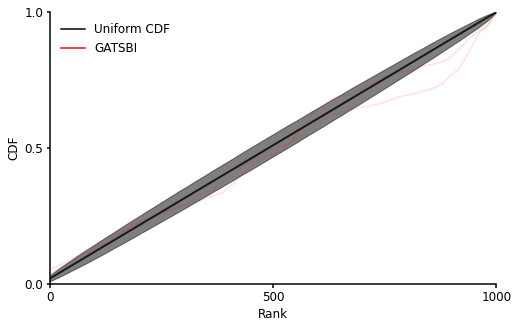

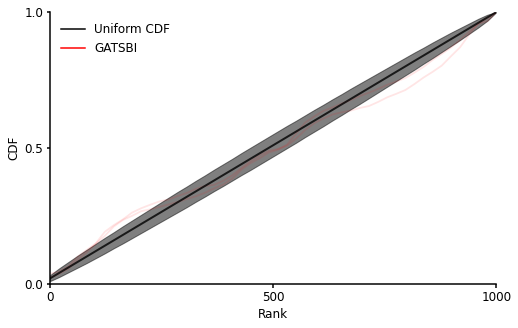

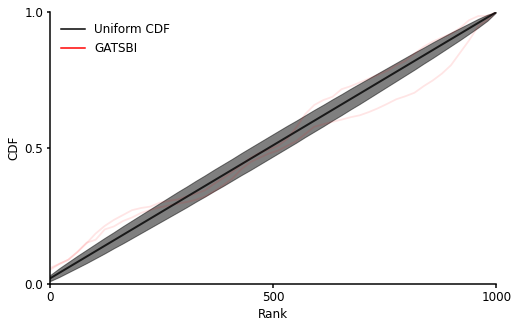

In [200]:
%%time

for task_name, df_in in zip(tasks, runs_list):

    print(task_name)
    
    task = sbibm.get_task(task_name)
    simulator = task.get_simulator()
    prior = task.get_prior()
    
    my_names_list = []
    
    for scoring_rule, plot_label in zip(scoring_rule_list, plot_labels):
            
        with open(join("..", "tasks", task_name, f"defaults{'_opt' if (task_name=='two_moons' and scoring_rule=='GAN') else ''}.yaml"), "r") as f:
            defaults = yaml.load(f, Loader=yaml.Loader)#
        config = NSp(**defaults)
        
        # Make proposal, generator and discriminator
        gen = make_generator(
            gen_seed=config.gen_seed,
            **config.gen_network_kwargs
        )        
        
        for n_sim in n_simulations:
            for n_gen in n_generator_list:
                
                if scoring_rule == "GAN" and n_gen != 20:
                    continue
        
                name = scoring_rule + "_" + str(n_sim) + "_" + str(n_gen)
                
                # check if the file f"plotting_data/shallow_water_model_calibration_metrics_{name}.pkl" exists; if it does, skip that
                if os.path.isfile(f"plotting_data/{task_name}_calibration_metrics_{name}.pkl"):
                    print(f"Skipping {name}")
                    continue

                print(name)
        
                # obtain the identifier
                df = df_in[df_in.apply(lambda x: scoring_rule in x["name"], axis=1)]
                df = df[df.num_training_simulations == n_sim]
                if scoring_rule != "GAN":
                    df = df[df.num_simulations_generator == n_gen]
                identifier = df["ID"].item()
                print(identifier)
        
                # obtain the path
                correct_folder = glob(root_folder + task_name + f"/wandb/*{identifier}*")
                if len(correct_folder) == 0:
                    print("No match")
                    continue
                correct_folder = correct_folder[0]
        
                checkpoint_to_load = correct_folder + "/files/checkpoint_models0.pt"
        
                # now should load the generative network for that folder:   
                try:
                    chpt = torch.load(checkpoint_to_load, map_location=torch.device('cpu'))
                    gen.load_state_dict(chpt["generator_state_dict"])
                except FileNotFoundError:
                    print("Could not load the generator")
                    continue
        
                if hasattr(task.prior_params, "high"):
                    # need only the upper bound, because prior bounds are symmetric for the tasks we consider
                    rej_thresh = task.prior_params["high"]
                else:
                    rej_thresh = None
        
                test_theta_fake, test_theta = generate_test_set_for_calibration(prior, simulator, gen, n_test_samples=1000,
                                                                                n_generator_simulations=1000,
                                                                                sample_seed=config.sample_seed,
                                                                                data_is_image=False,
                                                                                rej_thresh=rej_thresh)
                                                                                
        
                fig_filename = join("..", "results", task_name) + f"/{scoring_rule}_" + str(defaults["num_simulations"])
        
                res = compute_calibration_metrics(test_theta_fake, test_theta, sbc_lines=True,
                                                  norm_rmse=task_name != "camera_model",
                                                  sbc_lines_kwargs={"name": plot_label,
                                                                    "filename": fig_filename + "_sbc_lines.pdf"},
                                                  sbc_hist_kwargs={"filename": fig_filename + "_sbc_hist.pdf"})
        
                my_names_list.append(name)
        
                a_file = open(f"plotting_data/{task_name}_calibration_metrics_{name}.pkl", "wb")
                pickle.dump(res, a_file)
                a_file.close()
        
                # wrap the generator so that it can generate multiple samples at once: 
                # gen_wrapped = WrapGenMultipleSimulations(gen, n_simulations=n_post_samples)                
        
                #break
            #break

# Tables

## Load the results from the disk

In [44]:
res_list_dict = {}
name_list_dict = {}

for task_name, df_in in zip(tasks, runs_list):

    print(task_name)
    
    res_list = []
    name_list = []
    
    for scoring_rule, plot_label in zip(scoring_rule_list, plot_labels):
        for n_sim in n_simulations:
            for n_gen in n_generator_list:
                
                if scoring_rule == "GAN" and n_gen != 20:
                    continue
        
                name = scoring_rule + "_" + str(n_sim) + "_" + str(n_gen)
                if scoring_rule == "GAN":
                    name_for_df = task_name + "_" + scoring_rule + "_" + str(n_sim) + "_"
                else:
                    name_for_df = task_name + "_"  + name 
                                
                a_file = open(f"plotting_data/{task_name}_calibration_metrics_{name}.pkl", "rb")
                output = pickle.load(a_file)
                res_list.append(output)
                a_file.close()

                name_list.append(name_for_df)
    
    res_list_dict[task_name] = res_list
    name_list_dict[task_name] = name_list
            

slcp
two_moons
gaussian_mixture
gaussian_linear
bernoulli_glm


In [45]:
# create a pandas dataframe for each task
res_df_dict = {}
for task_name in tasks:
    res_df = pd.DataFrame(res_list_dict[task_name])
    res_df["name"] = name_list_dict[task_name]
    res_df_dict[task_name] = res_df
    # set index to name
    res_df.set_index("name", inplace=True)

In [46]:
# merge each of them to the original runs_list dataframe
for task_name, runs_list_df in zip(tasks, runs_list):
    res_df = runs_list_df[["name", "global_step", "_runtime", "c2st_mean", "c2st_std"]].merge(res_df_dict[task_name], on="name")
    print(len(res_df))
    res_df_dict[task_name] = res_df
    # break

27
27
27
27
27


In [47]:
res_df["name"]

0                bernoulli_glm_GAN_100000_
1                 bernoulli_glm_GAN_10000_
2                  bernoulli_glm_GAN_1000_
3     bernoulli_glm_kernel_score_100000_20
4     bernoulli_glm_kernel_score_100000_10
5      bernoulli_glm_kernel_score_100000_5
6      bernoulli_glm_kernel_score_100000_3
7     bernoulli_glm_energy_score_100000_20
8     bernoulli_glm_energy_score_100000_10
9      bernoulli_glm_energy_score_100000_5
10     bernoulli_glm_energy_score_100000_3
11     bernoulli_glm_kernel_score_10000_20
12     bernoulli_glm_kernel_score_10000_10
13      bernoulli_glm_kernel_score_10000_5
14      bernoulli_glm_kernel_score_10000_3
15     bernoulli_glm_energy_score_10000_20
16     bernoulli_glm_energy_score_10000_10
17      bernoulli_glm_energy_score_10000_5
18      bernoulli_glm_energy_score_10000_3
19      bernoulli_glm_kernel_score_1000_20
20      bernoulli_glm_kernel_score_1000_10
21       bernoulli_glm_kernel_score_1000_5
22       bernoulli_glm_kernel_score_1000_3
23      ber

In [48]:
res_df.columns

Index(['name', 'global_step', '_runtime', 'c2st_mean', 'c2st_std',
       'cal_err_val_mean', 'r2_val_mean', 'rmse_val_mean', 'cal_err_val_std',
       'r2_val_std', 'rmse_val_std', 'crps_val_mean', 'crps_val_std',
       'sbc_lines'],
      dtype='object')

## Now create the tables

In [25]:
#! pip install tabulate
from tabulate import tabulate
from copy import deepcopy

In [52]:
def print_table(metrics_dict, task_name,  field="c2st", latex=False, file=None, tranpose=False):

    metrics_df = res_df_dict[task_name]
    
    has_std = False
    
    if field in ["rmse", "cal_err", "r2", "c2st", "crps"]:
        has_std = True
        if field not in ["c2st"]:
            field += "_val"

    name_list = ["",]
    
    n_sim_list = [1000,10000,100000]
    all_lists = []
    
    for i, n_sim in enumerate(n_sim_list):
       
        # extract subset of metrics_df with those number of simulations only
        metrics_df_subset = metrics_df[metrics_df["name"].apply(lambda x: f"_{n_sim}_" in x)]
        
        
        # Define the custom order
        custom_order = [f'GAN_{n_sim}_', f'energy_score_{n_sim}_3', f'energy_score_{n_sim}_5', f'energy_score_{n_sim}_10', f'energy_score_{n_sim}_20', f'kernel_score_{n_sim}_3', f'kernel_score_{n_sim}_5', f'kernel_score_{n_sim}_10', f'kernel_score_{n_sim}_20']
        custom_order = [f"{task_name}_" + elem for elem in custom_order]
        
        # Convert the 'name' column to a categorical type with the custom order
        metrics_df_subset['name'] = pd.Categorical(metrics_df_subset['name'], categories=custom_order, ordered=True)
        
        # Sort the DataFrame by the 'name' column
        metrics_df_subset = metrics_df_subset.sort_values(by='name')

        # initialize the name_list if i == 0
        if i == 0:
            for name in metrics_df_subset["name"]:
                # convert the name to a good one
                if "GAN" in name:
                    name_for_list = "GATSBI"
                elif    "energy" in name:
                    name_for_list = "Energy " + name.split("_")[-1] 
                elif "kernel" in name:
                    name_for_list = "Kernel" + name.split("_")[-1]
                else:
                    raise ValueError("Unknown name")
                name_list.append(name_for_list)            
            all_lists.append(name_list)

        inner_list = [n_sim]    
        # loop over the rows of the subset
        for index, row in metrics_df_subset.iterrows():
            if has_std:
                inner_list.append(f"{row[f'{field}_mean']:.2f} $\pm$ {row[f'{field}_std']:.2f}" )
            else:
                inner_list.append(f"{row[f'{field}']:.2f}" )
       
        all_lists.append(deepcopy(inner_list))
    
    if tranpose: 
        all_lists = list(map(list, zip(*all_lists)))

    if file is None:
        if latex: 
            print(tabulate(all_lists, headers="firstrow", tablefmt="latex_raw"))
        else:
            print(tabulate(all_lists, headers="firstrow")) #  tablefmt="latex_booktabs"
    else: 
        with open(file, 'w') as f:
            if latex: 
                f.write(tabulate(all_lists, headers="firstrow", tablefmt="latex_raw"))
            else:
                f.write(tabulate(all_lists, headers="firstrow")) #  tablefmt="latex_booktabs"        

Write all tables and store them.

In [55]:
for task in tasks:
    for metric in ["c2st", "crps", "global_step", "_runtime", "cal_err"]: 
        print_table(res_df_dict, task_name=task, field=metric, file=f"tables/{task}_{metric}", latex=True)

/tmp/ipykernel_6710/4156184295.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_df_subset['name'] = pd.Categorical(metrics_df_subset['name'], categories=custom_order, ordered=True)
/tmp/ipykernel_6710/4156184295.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_df_subset['name'] = pd.Categorical(metrics_df_subset['name'], categories=custom_order, ordered=True)
/tmp/ipykernel_6710/4156184295.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

### Fix now n_gen=20 and create a single table for all entries

Each column should be GAN/En/Kernel. Rows are then the different metrics

In [62]:
def print_table_fixed_n_gen_n_sim(metrics_dict, task_name, n_gen=20, n_sim=100000, latex=False, file=None, tranpose=False):

    metrics = [["c2st_std", "c2st_mean",], ['cal_err_val_std', 'cal_err_val_mean'], ['crps_val_std', 'crps_val_mean'],
                    ['_runtime'], ['global_step']]
    metric_names = [r"C2ST $ \downarrow $", r"Cal. Err. $ \downarrow $", r"CRPS $ \downarrow $", "Runtime (sec)", "Early stopping epoch"]
    
    metrics_df = metrics_dict[task_name]
    
    # only keep those with those value of n_gen and n_sim
    metrics_df = metrics_df[metrics_df["name"].apply(lambda x: f"_{n_sim}_" in x)]
    metrics_df = metrics_df[metrics_df["name"].apply(lambda x: f"_{n_gen}" in x or "GAN" in x)]
    
    # sort by name
    metrics_df = metrics_df.sort_values(by="name")
    
    print(len(metrics_df))
        
    all_lists = []

    name_list = ["",]
    for name in metrics_df["name"]:
        # convert the name to a good one
        if "GAN" in name:
            name_for_list = "GATSBI"
        elif    "energy" in name:
            name_for_list = "Energy "  
        elif "kernel" in name:
            name_for_list = "Kernel" 
        else:
            raise ValueError("Unknown name")
        name_list.append(name_for_list)            
            
    all_lists.append(name_list)

    for name, metric in zip(metric_names, metrics): 
        inner_list = [name]    
        for index, row in metrics_df.iterrows():
            if len(metric)==2:
                inner_list.append(f"{row[metric[1]]:.2f} $\pm$ {row[metric[0]]:.2f}" )
            else:
                inner_list.append(f"{row[metric[0]]:.2f}" )
                
        all_lists.append(deepcopy(inner_list))
    if tranpose: 
        all_lists = list(map(list, zip(*all_lists)))
    
    if file is None:
        if latex: 
            print(tabulate(all_lists, headers="firstrow", tablefmt="latex_raw"))
        else:
            print(tabulate(all_lists, headers="firstrow")) #  tablefmt="latex_booktabs"
    else: 
        with open(file, 'w') as f:
            if latex: 
                f.write(tabulate(all_lists, headers="firstrow", tablefmt="latex_raw"))
            else:
                f.write(tabulate(all_lists, headers="firstrow")) #  tablefmt="latex_booktabs"

In [64]:
n_gen = 20 
n_sim = 100000

for task in tasks:
    print_table_fixed_n_gen_n_sim(res_df_dict, task, n_gen=n_gen, n_sim=n_sim, latex=True, file=f"tables/{task}_all_metrics_n_gen={n_gen}_n_sim={n_sim}", tranpose=True)

3
3
3
3
3


# Generate a posterior image with the various methods



In [91]:
import altair as alt
alt.renderers.enable('altair_saver', fmts=['vega-lite', 'png'])

RendererRegistry.enable('altair_saver')

In [94]:
from selenium import webdriver
from selenium.webdriver.firefox.service import Service

# Create a Service object with the path to the Firefox driver
service = Service('/usr/local/bin/geckodriver')

# Pass the Service object to webdriver.Firefox
driver = webdriver.Firefox(service=service)

In [95]:
root_folder = "../results/"

In [98]:
task_name_list = ["slcp", "two_moons", "gaussian_mixture", "gaussian_linear", "bernoulli_glm"]
obs_numbers = [3, 2, 1, 1, 1]
df_list = [runs_df_slcp, runs_df_two_moons, runs_df_gaussian_mixture, runs_df_gaussian_linear, runs_df_bernoulli_glm]

# all possible combinations - we do not care about all of these
scoring_rule_list = ["energy_score", "kernel_score", "GAN"]
plot_labels = ["Energy Score", "Kernel Score", "GATSBI"]
n_gen_list = [3, 5, 10, 20]
n_sim_list = [1000, 10000, 100000]

scoring_rule_list = ["energy_score", "GAN"]
plot_labels = ["Energy Score", "GATSBI"]
n_gen_list = [20]
n_sim_list = [100000]

for df_in, task_name, obs_number in zip(df_list, task_name_list, obs_numbers):
    print(task_name)
    for scoring_rule, label in zip(scoring_rule_list, plot_labels):
        if scoring_rule == "GAN" and task_name in ["slcp", "two_moons"]:
            continue
        for n_gen in n_gen_list:
            for n_sim in n_sim_list:
                
                if scoring_rule == "GAN" and n_gen != 20:
                    continue

                # obtain the identifier
                df = df_in[df_in.apply(lambda x: scoring_rule in x["name"], axis=1)]
                df = df[df.num_training_simulations == n_sim]
                if scoring_rule != "GAN":
                    df = df[df.num_simulations_generator == n_gen]
                identifier = df["ID"].item()
                print(identifier)

                # obtain the path
                correct_folder = glob(root_folder + task_name + f"/wandb/*{identifier}*")
                if len(correct_folder) == 0:
                    print("No match")
                    continue
                correct_folder = correct_folder[0]
    
                # load posterior samples
                samples = np.load(correct_folder + "/files/gatsbi_results/" + f"gatsbi_samples_obs_num_{obs_number}.npy")

                # plot the samples
                chart = fig_posterior(
                    task_name=task_name,
                    num_observation=obs_number,
                    samples_tensor=torch.tensor(samples),
                    samples_name=label,
                    samples_color="#EC051C")
            
                # save the chart
                chart.save(f"./plots/{task_name}/posterior_samples_{scoring_rule}_{n_gen}_{n_sim}.png", scale_factor=2 ,webdriver='firefox',  )    
#                 

slcp
2z0jopb2


two_moons
rhm2nr2d
gaussian_mixture
d4o9e99p
scok3zmk
gaussian_linear
uy6b21zo
66r3qk3g
bernoulli_glm
yvpqfvxx
0kz86t84
